# Final project - ORB: an efficient aleternative to SIFT or SURF


## Libraries


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Test image import


In [2]:
# We load the grayscale image using imread and specifying that it's a grayscale image in the second argument
FILEPATH = "./data/"
crowd = cv2.imread(FILEPATH + 'crowd.jpg', cv2.IMREAD_GRAYSCALE)

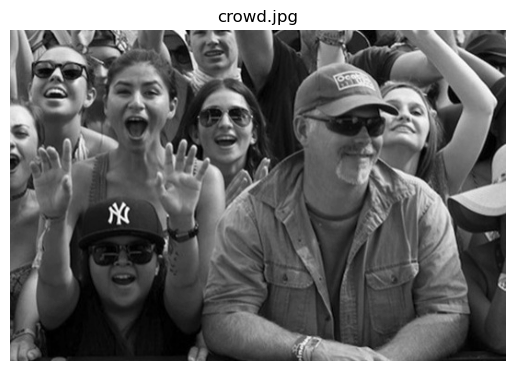

In [3]:
##Display loaded image

plt.imshow(crowd, cmap='gray')
plt.axis('off')
plt.title("crowd.jpg")
plt.show()

## ORB Feature descriptor


The ORB feature descriptor can be decomposed into its base blocks :

- FAST Algorithm ;
- Angle computation ;
- Brief descriptors.

We'll look at all those elements independently in this section.


### FAST-9 Algorithm


First the FAST algorithm (and its version FAST-9) compute brute feature descriptor in the image. We'll also implement non maximum suppresion to only compute a small sample of points of interest to reduce computation times.


In [4]:
def detect_fast_keypoints(image:np.ndarray, threshold:int=50, NMS_radius:int=3):
    """Basic FAST-9 feature descriptor

    Args:
        image (np.ndarray): Image input.
        threshold (int, optional): Threshold for the FAST_9 Algorithm. Defaults to 50.
        NMS_radius (int, optional): Maximum radius for non-maximum suppresion. Defaults to 3.
    """
    keypoints = []
    keypoints_scores = {}
    height, width = image.shape
    min_offset = 3

    ## Relative coordinates of circular neighborhood in FAST-9
    CIRCLE_OFFSETS = np.array([(0,-3), (1, -3), (2, -2), (3, -1),
                               (3, 0), (3, 1), (2, 2), (1, 3),
                               (0, 3), (-1, 3), (-2, 2), (-3, 1),
                               (-3, 0), (-3, -1), (-2, -2), (-1, -3)
                               ])
    
    for y in range(min_offset, height - min_offset):
        for x in range(min_offset, width - min_offset):
            center_intensity = image[y, x]
            circle_pixels = np.array([image[y + dy,  x + dx] for dx, dy in CIRCLE_OFFSETS])

            ## Check if pixels are brighter/darker than centroid
            brighter_pixels = circle_pixels > (center_intensity + threshold)
            darker_pixels = circle_pixels < (center_intensity - threshold)

            ## A point is a corner if at least 9 pixels are brighter/darker than centroid
            if (np.sum(brighter_pixels) >= 9) or (np.sum(darker_pixels) >= 9):
                keypoints.append((x, y))

                ## Compute V-Score
                keypoints_scores[(x, y)] = max(np.sum(brighter_pixels), np.sum(darker_pixels))

    # Non Maximum Suppression
    sorted_keypoints = sorted(keypoints, key = lambda kp: keypoints_scores.get(kp))
    important_keypoints = []

    for x, y in sorted_keypoints:

        if any((abs(x - px) <= NMS_radius and abs(y-py) <= NMS_radius) for px, py in important_keypoints):
            continue

        important_keypoints.append((x, y))


    return np.array(important_keypoints)

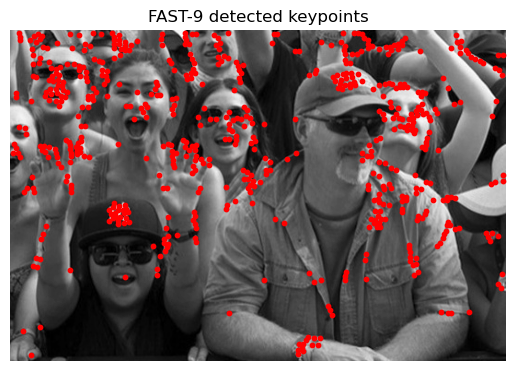

Number of FAST keypoints : 617


In [5]:
# --- TEST IMAGE ---
keypoints = detect_fast_keypoints(crowd, threshold=50)

# --- Displaying FAST keypoints ---
plt.imshow(crowd, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=10)
plt.title("FAST-9 detected keypoints")
plt.axis("off")
plt.show()

print("Number of FAST keypoints :", len(keypoints))

### Orientation by Intensity Centroid


We'll then look at computing the orientation of those keypoints using the Intensity Centroid method, which is much more easy to compute than other gradients methods such as in SIFT.


In [6]:
def compute_keypoints_orientation(image:np.ndarray, keypoints:np.ndarray, patch_size:int=31):
    """Compute orientation of keypoints using the Intensity Centroid method

    Args:
        image (np.ndarray): Image input.
        keypoints (np.ndarray): Keypoints list.
        patch_size (int, optional): Size of the patch around the keypoint. Defaults to 31.
    """ 
    orientations = []

    for x_k, y_k in keypoints:
        ## Patch boundaries
        x_min, x_max = max(x_k - patch_size //2, 0), min(x_k + patch_size // 2, image.shape[1])
        y_min, y_max = max(y_k - patch_size //2, 0), min(y_k + patch_size // 2, image.shape[0])

        patch = image[y_min:y_max, x_min:x_max]
        
        ## Compute intensity moments
        X, Y = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))

        m10 = np.sum(X * patch)
        m01 = np.sum(Y * patch)

        # Compute orientation
        theta = np.arctan2(m01, m10)

        orientations.append(theta)

    return np.array(orientations)

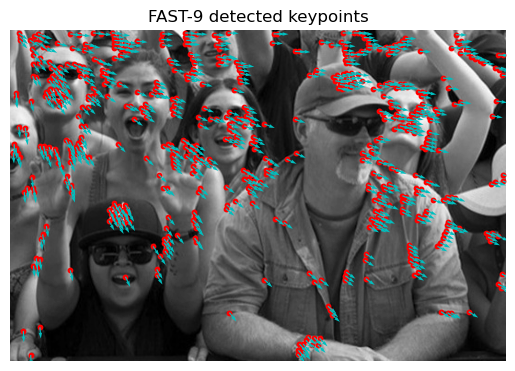

Number of FAST keypoints : 617


In [7]:
# --- TEST IMAGE ---
orientations = compute_keypoints_orientation(crowd, keypoints)

# --- Displaying FAST keypoints with orientations---
plt.imshow(crowd, cmap='gray')

plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=10)
plt.quiver(keypoints[:, 0], keypoints[:, 1], np.cos(orientations) * 20, np.sin(orientations) * 20, color='c', angles='xy')

plt.title("FAST-9 detected keypoints")
plt.axis("off")
plt.show()

print("Number of FAST keypoints :", len(keypoints))

### BRIEF Descriptors


Finally, we compute for each keypoint a binary descriptor base don the intensity of random pixels selectd in a patch around the keypoint. We here implement a steered version of the BRIEF algorithm using the previously computed orientations.


In [8]:
def compute_steered_brief(image:np.ndarray, keypoints:np.ndarray, orientations:np.ndarray, patch_size:int=31, n:int=256):
    """Compute BRIEF binary descriptor for given keypoints.

    Args:
        image (np.ndarray): Image input.
        keypoints (np.ndarray): Image input.
        orientations (np.ndarra): Orientation of keypoints.
        patch_size (int, optional): Size of the patch around the keypoint. Defaults to 31.
        n (int, optional): Length of description vector. Defaults to 256.
    """
    image = cv2.GaussianBlur(image, (5, 5), 0) # Smoothing image for robustness
    descriptors = []

    ## Generating sampling pairs
    half_patch = patch_size // 2
    sampling_pairs = np.random.randint(-half_patch, half_patch, (n, 2, 2))


    for (x, y), theta in zip(keypoints, orientations):
        
        patch = image[y - half_patch:y + half_patch, x - half_patch:x + half_patch]

        # Skip keypoints near the edges
        if (x - half_patch < 0 or x + half_patch >= image.shape[1] or
            y - half_patch < 0 or y + half_patch >= image.shape[0]):
            continue

        # Rotate sampling pattern
        R_theta = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_sampling_pairs = np.dot(sampling_pairs, R_theta).astype(int)

        # Avoid out-of-bounds errors by clipping rotated values
        rotated_sampling_pairs = np.clip(rotated_sampling_pairs, -half_patch+1, half_patch-1)        

        descriptor = []
        
        for (p1, p2) in rotated_sampling_pairs:
            intensity1 = patch[p1[1] + half_patch, p1[0] + half_patch]
            intensity2 = patch[p2[1] + half_patch, p2[0] + half_patch]
            descriptor.append(1 if intensity1 < intensity2 else 0)

        descriptors.append(descriptor)

    return np.array(descriptors)

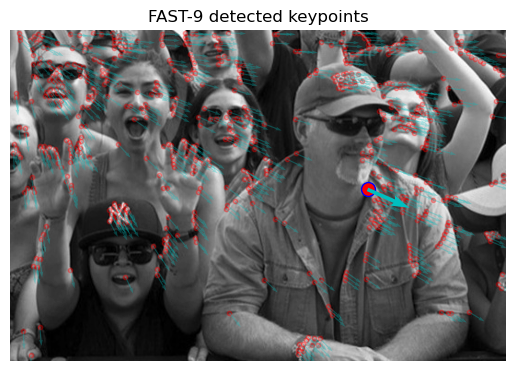

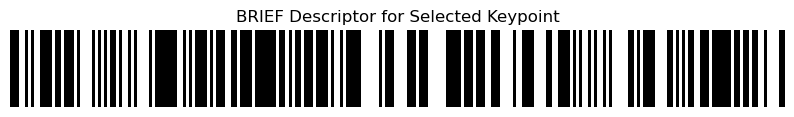

In [9]:
# --- TEST IMAGE ---
brief = compute_steered_brief(crowd, keypoints, orientations)

# --- Displaying FAST keypoints ---
plt.imshow(crowd, cmap='gray')

plt.scatter(keypoints[:, 0], keypoints[:, 1], color='r', s=10, alpha=.3)
plt.quiver(keypoints[:, 0], keypoints[:, 1], np.cos(orientations) * 20, np.sin(orientations) * 20, color='c', angles='xy', scale_units='xy', scale=1, alpha=.3)

random_index = np.random.randint(0, len(brief))
plt.scatter(keypoints[random_index, 0], keypoints[random_index, 1], color='r', s=100, edgecolors='b')
plt.quiver(keypoints[random_index, 0], keypoints[random_index, 1], np.cos(orientations[random_index]) * 50, np.sin(orientations[random_index]) * 50, color='c', angles='xy', scale_units='xy', scale=1)

plt.title("FAST-9 detected keypoints")
plt.axis("off")

descriptor_img = np.array(brief[random_index], dtype=np.uint8).reshape(1, -1)  # Convert descriptor to Binary image
fig2, ax2 = plt.subplots(figsize=(10, 1))
ax2.imshow(descriptor_img, cmap="gray", aspect="auto")
ax2.set_title("BRIEF Descriptor for Selected Keypoint")
ax2.axis("off")

plt.show()

## Toy experiments

Here are some Toy experiments using the ORB feature descriptor. To simplify the use cases, we'll use the already implemented ORB descriptor in openCV.


### Feature matching between images (rotation invariant ORB)


Since ORB is rotation invariant, we'll firs show this using the same test image and comparing keypoints between the original image and its rotated counterpart. We'll then use the feature matching by brute-force from opencv to compute the poisiton of a box in an image.

Note that this method could also be used for panormama stitching, using the homography method (same as in the first TP).


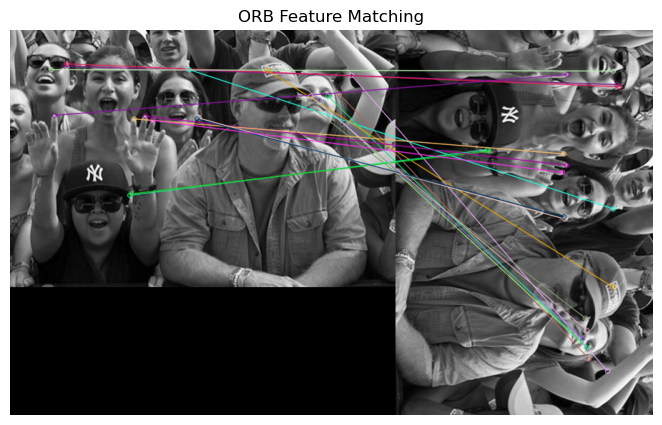

In [10]:
image1 = cv2.imread('./data/crowd.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)  # Rotated version of image1

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
kp1, des1 = orb.detectAndCompute(image1, None)
kp2, des2 = orb.detectAndCompute(image2, None)

# Match descriptors using Brute-Force Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
matched_image = cv2.drawMatches(image1, kp1, image2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show result
plt.figure(figsize=(10, 5))
plt.imshow(matched_image, cmap='gray')
plt.title("ORB Feature Matching")
plt.axis("off")
plt.show()

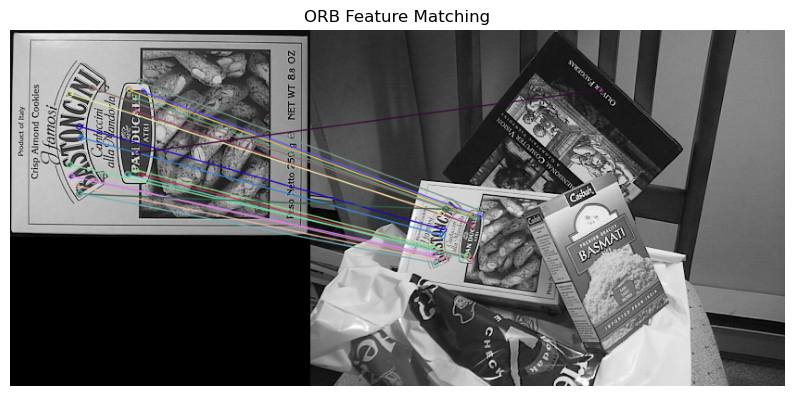

In [11]:
image1 = cv2.imread('./data/box.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('./data/box_in_scene.png', cv2.IMREAD_GRAYSCALE)

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
kp1, des1 = orb.detectAndCompute(image1, None)
kp2, des2 = orb.detectAndCompute(image2, None)

# Match descriptors using Brute-Force Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
matched_image = cv2.drawMatches(image1, kp1, image2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show result
plt.figure(figsize=(10, 5))
plt.imshow(matched_image, cmap='gray')
plt.title("ORB Feature Matching")
plt.axis("off")
plt.show()

### Object tracking


Since ORB is easy to compute, we can use those descriptor to track keypoints in a live video, as demonstrated below.


In [13]:
# Open a video file or webcam
cap = cv2.VideoCapture("./data/VOT-Basket.mp4")  # Use 0 for webcam

# Initialize ORB detector
orb = cv2.ORB_create()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    
    # Draw keypoints
    frame_with_keypoints = cv2.drawKeypoints(frame, keypoints, None, color=(0, 255, 0), flags=0)

    cv2.imshow('ORB Keypoint Tracking', frame_with_keypoints)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
        break

cap.release()
cv2.destroyAllWindows()
